In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
from torchvision import transforms

### Initializing Data

In [23]:
# initializing MNIST data, preprocessing

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
train_loader = torch.utils.data.DataLoader(mnist_trainset, shuffle=True, num_workers=2)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
test_loader = torch.utils.data.DataLoader(mnist_testset, shuffle=False, num_workers=2)

In [24]:
train_x = mnist_trainset.data.clone().detach().numpy().reshape(-1, 28 * 28)
train_y = mnist_trainset.targets.clone().detach().numpy()

train_y_one_hot = np.zeros((train_y.shape[0], train_y.max() + 1))
train_y_one_hot[np.arange(train_y.shape[0]), train_y] = 1

train_x.shape, train_y_one_hot.shape

((60000, 784), (60000, 10))

In [25]:
test_x = mnist_testset.data.clone().detach().numpy().reshape(-1, 28 * 28)
test_y = mnist_testset.targets.clone().detach().numpy()

test_y_one_hot = np.zeros((test_y.shape[0], test_y.max() + 1))
test_y_one_hot[np.arange(test_y.shape[0]), test_y] = 1


test_x.shape, test_y.shape, test_y_one_hot.shape

((10000, 784), (10000,), (10000, 10))

In [26]:
d = 28 * 28
d1 = 300
k = 10

### My own implementation

In [27]:
def sigmoid(x):
  return np.exp(np.fmin(x, 0)) / (1 + np.exp(-np.abs(x)))

def d_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

In [28]:
# def softmax(output_vector):
#   # sum = np.sum(np.exp(output_vector))
#   # softmax_vector = np.empty_like(output_vector, float)

#   # for i in range(len(softmax_vector)):
#   #   softmax_vector[i] = np.exp(output_vector[i]) / sum
#   return np.exp(output_vector) - np.max(output_vector) / np.sum(np.exp(output_vector) - np.max(output_vector))

def softmax(output_vector):
    numerator = np.exp(output_vector)
    denominator = numerator.sum(axis=1, keepdims=True)
    return numerator / denominator

In [29]:
def cross_entropy_loss(y_hat, y):
  return -1 * np.sum(y * np.log(y_hat + 1e-5))#, axis = 1)

In [30]:
def forward(x, y):
  global W_1, W_2
  A = x @ W_1
  B = sigmoid(A)
  C = B @ W_2

  y_hat = softmax(C)
  loss = cross_entropy_loss(y_hat, y) / x.shape[0]

  return A, B, C, y_hat, loss

In [31]:
learning_rate = 0.01

In [32]:
def backward(A, B, C, y_hat, loss, x, y):
  global W_1, W_2

  dL_dy_hat = y_hat - y
  # dy_hat_dB = y_hat * (1 - y_hat)
  # dB_dA = np.dot(dL_dy_hat, W_2.T) * sigmoid(A) * (1 - sigmoid(A))

  dL_dW_1 = np.dot(x.T, np.dot(dL_dy_hat, W_2.T) * sigmoid(A) * (1 - sigmoid(A)))

  # dL_dW_1 = np.dot(np.dot(dL_dy_hat, dy_hat_dB.T), A)
  # print(dL_dW_1)
  # dL_dW_1 = np.dot(x.T, dB_dA)

  # dA_dW_1 = np.dot(W_2.T, np.dot(A.T, (1 - A)))

  # print(dL_dy_hat.shape, dy_hat_dB.shape, dA_dW_1.shape, x.shape)
  # dL_dW_2 = np.dot(np.dot(np.dot(dL_dy_hat.T, dy_hat_dB.T), dA_dW_1), x)
  # dL_dW_2 = dL_dy_hat * dy_hat_dB * dA_dW_1 * x


  dL_dW_2 = np.dot(B.T, dL_dy_hat)
  # dL_dW_2 = ((W_2.T @ (y_hat - y))) * sigmoid(A) * (1 - sigmoid(A)) * x.T
  # print(dL_dW_1)
  # print(dL_dW_2)

  W_1 -= learning_rate * dL_dW_1
  W_2 -= learning_rate * dL_dW_2

  return W_1, W_2

In [33]:
def predict(x):
  global W_1, W_2
  A = x @ W_1
  B = sigmoid(A)
  C = B @ W_2

  return np.argmax(C, axis = 1)

In [34]:
def eval(x, y):
    y_pred = predict(x)
    correct = np.sum(y_pred == np.argmax(y, axis=1))
    return correct / x.shape[0]

In [35]:
epochs = 25
batch_size = 32

training_losses = []
testing_losses = []
testing_errors = []
# random weight vector initialization, in the range [-1.0, 1.0]
W_1 = np.random.uniform(low=-1.0, high=1.0, size=(d, d1))
W_2 = np.random.uniform(low=-1.0, high=1.0, size=(d1, k))


for epoch in range(epochs):
  overall_loss = 0
  # next 3 lines adapted from https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/
  for i in range(0, train_x.shape[0], batch_size):
    x_train_batch = train_x[i : i + batch_size]
    y_train_batch = train_y_one_hot[i : i + batch_size]

    # forward pass
    A, B, C, y_hat, loss = forward(x_train_batch, y_train_batch)
    # print(loss)
    overall_loss += loss / x_train_batch.shape[0]
    # print(overall_loss)

    # backwards pass
    W_1, W_2 = backward(A, B, C, y_hat, loss, x_train_batch, y_train_batch)

  # accuracies - need test error and learning curve
  loss_avg = overall_loss / (train_x.shape[0] / batch_size)
  training_losses.append(loss_avg)

  _, _, _, _, test_loss = forward(test_x, test_y_one_hot)
  testing_losses.append(test_loss)

  testing_error = 1 - eval(test_x, test_y_one_hot)
  testing_errors.append(testing_error)

print("Accuracy: " + str((1- testing_errors[-1]) * 100) + "%")

Accuracy: 52.59%


In [36]:
print("Accuracy: " + str((1- testing_errors[-1]) * 100) + "%")

Accuracy: 52.59%


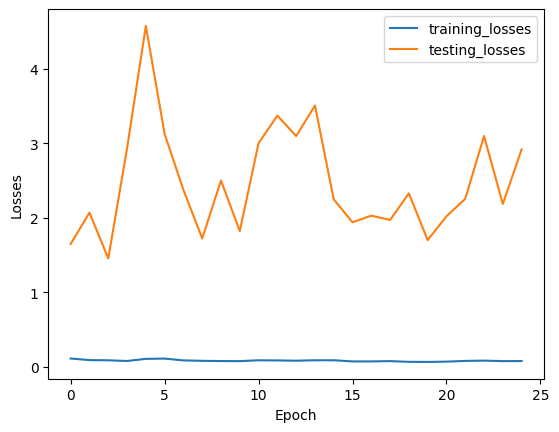

In [37]:
plt.plot(range(epochs), training_losses, label="training_losses")
plt.plot(range(epochs), testing_losses, label="testing_losses")
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.show()

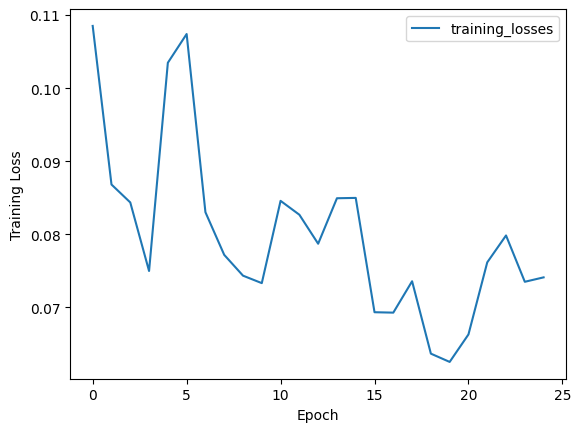

In [38]:
plt.plot(range(epochs), training_losses, label="training_losses")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

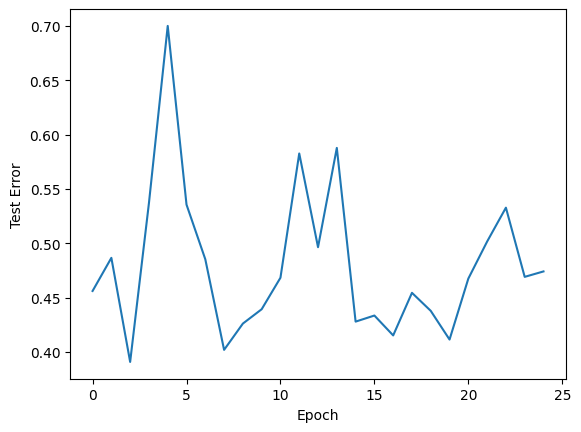

In [39]:
plt.plot(range(epochs), testing_errors)
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.show()